In [1]:
import os
import shutil
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.callbacks import TensorBoard
import time
from tensorflow.keras import backend as K

data_path = r"D:\Hackathon\Carla\Windows\CarlaBuild\Behavioural_cloning\train"
data_dir_list = os.listdir(data_path)
os.chdir(data_path)

img_rows = 224
img_cols = 224
num_channel = 3

In [2]:
NAME = "Test1-{}".format(int(time.time()))
tensorboard = TensorBoard(log_dir='logs/{}'.format(NAME), write_images = True)

In [3]:
#LOADING DATA
img_data = np.load('images.npy')
labels = np.load('labels.npy')

In [4]:
print(img_data.shape)

(15007, 224, 224, 3)


(224, 224, 3)


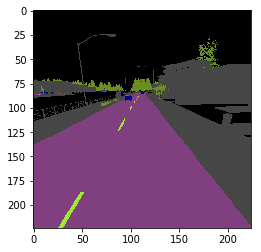

In [5]:
# PLOT A SINGLE IMAGE
print(img_data[1].shape)
plt.imshow(img_data[1])

In [6]:
print(labels[1])

['0.60' '0.105042' '0']


In [7]:
x, y = shuffle(img_data, labels, random_state = 65168)

In [8]:
print(y[1])

['0.60' '0.016007' '0']


In [9]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, random_state = 42)

In [10]:
input_shape = img_data[0].shape
print(input_shape)

(224, 224, 3)


In [11]:
def throttle_mse(y_true, y_pred):
    return K.mean(K.square(y_true[:,0] - y_pred[:,0]), axis = -1)
    
def steer_mse(y_true, y_pred):
    return K.mean(K.square(y_true[:,1] - y_pred[:,1]), axis = -1)

def brake_mse(y_true, y_pred):
    return K.mean(K.square(y_true[:,2] - y_pred[:,2]), axis = -1)

In [16]:
K.clear_session()

In [17]:
# Defining the model
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size=(3 ,3), input_shape = input_shape, activation = "relu"))
model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size=(3 ,3), activation = "relu"))
model.add(tf.keras.layers.MaxPooling2D(pool_size = (2,2)))

model.add(tf.keras.layers.Conv2D(filters = 128, kernel_size=(3,3), activation = "relu"))
model.add(tf.keras.layers.MaxPooling2D(pool_size = (2,2)))
model.add(tf.keras.layers.Conv2D(filters = 128, kernel_size=(3,3), activation = "relu"))
model.add(tf.keras.layers.MaxPooling2D(pool_size = (2,2)))

model.add(tf.keras.layers.Conv2D(filters = 256, kernel_size=(3,3), activation = "relu"))
model.add(tf.keras.layers.MaxPooling2D(pool_size = (2,2)))
model.add(tf.keras.layers.Conv2D(filters = 256, kernel_size=(3,3), activation = "relu"))
model.add(tf.keras.layers.MaxPooling2D(pool_size = (2,2)))
model.add(tf.keras.layers.Conv2D(filters = 256, kernel_size=(3,3), activation = "relu"))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(256, activation = "relu" ))
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(3))
          
model.summary()

model.compile(loss = 'mse', optimizer = tf.keras.optimizers.Adam(lr = 0.0005), metrics = [throttle_mse, steer_mse, brake_mse])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 108, 108, 128)     73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 52, 52, 128)       147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 128)       0         
__________

In [18]:
filepath = r"D:\Hackathon\Carla\Windows\CarlaBuild\Behavioural_cloning\models\lowlossmodel"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor = 'val_loss', verbose = 0, save_best_only = True, mode = 'min', save_weights_only = False)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'loss', verbose = 1, factor = 0.5, cooldown = 5, patience = 10, min_lr = 0.000005)

In [19]:
hist = model.fit(x_train, y_train, batch_size = 64, epochs = 500, validation_split = 0.1, shuffle = True, callbacks = [checkpoint, tensorboard, reduce_lr])

Train on 12155 samples, validate on 1351 samples
Epoch 1/500
12155/12155 [==============================] - 79s 7ms/step - loss: 0.0301 - throttle_mse: 0.0231 - steer_mse: 0.0258 - brake_mse: 0.0415 - val_loss: 0.0128 - val_throttle_mse: 0.0045 - val_steer_mse: 0.0228 - val_brake_mse: 0.0112
Epoch 2/500
12155/12155 [==============================] - 80s 7ms/step - loss: 0.0170 - throttle_mse: 0.0101 - steer_mse: 0.0220 - brake_mse: 0.0189 - val_loss: 0.0119 - val_throttle_mse: 0.0078 - val_steer_mse: 0.0186 - val_brake_mse: 0.0093
Epoch 3/500
12155/12155 [==============================] - 79s 7ms/step - loss: 0.0134 - throttle_mse: 0.0087 - steer_mse: 0.0158 - brake_mse: 0.0159 - val_loss: 0.0084 - val_throttle_mse: 0.0035 - val_steer_mse: 0.0128 - val_brake_mse: 0.0089
Epoch 4/500
12155/12155 [==============================] - 79s 6ms/step - loss: 0.0115 - throttle_mse: 0.0082 - steer_mse: 0.0113 - brake_mse: 0.0151 - val_loss: 0.0094 - val_throttle_mse: 0.0032 - val_steer_mse: 0.0116

12155/12155 [==============================] - 79s 6ms/step - loss: 0.0027 - throttle_mse: 0.0017 - steer_mse: 0.0025 - brake_mse: 0.0040 - val_loss: 0.0056 - val_throttle_mse: 0.0029 - val_steer_mse: 0.0057 - val_brake_mse: 0.0083
Epoch 35/500
12155/12155 [==============================] - 78s 6ms/step - loss: 0.0024 - throttle_mse: 0.0015 - steer_mse: 0.0022 - brake_mse: 0.0036 - val_loss: 0.0057 - val_throttle_mse: 0.0028 - val_steer_mse: 0.0063 - val_brake_mse: 0.0078
Epoch 36/500
12155/12155 [==============================] - 78s 6ms/step - loss: 0.0022 - throttle_mse: 0.0014 - steer_mse: 0.0018 - brake_mse: 0.0034 - val_loss: 0.0055 - val_throttle_mse: 0.0026 - val_steer_mse: 0.0061 - val_brake_mse: 0.0077
Epoch 37/500
12155/12155 [==============================] - 79s 6ms/step - loss: 0.0023 - throttle_mse: 0.0014 - steer_mse: 0.0021 - brake_mse: 0.0033 - val_loss: 0.0053 - val_throttle_mse: 0.0026 - val_steer_mse: 0.0056 - val_brake_mse: 0.0076
Epoch 38/500
12155/12155 [=======

KeyboardInterrupt: 

In [20]:
model.save('Final_Model')

In [21]:
test_loss, throttle, steer, brake = model.evaluate(x_test, y_test)
print(test_loss, throttle, steer, brake)

1501/1501 [==============================] - 6s 4ms/step
0.004747967610972065 0.0022302108305420473 0.0051628982663842705 0.006850793735204599


In [22]:
os.chdir(r"D:\Hackathon\Carla\Windows\CarlaBuild\Behavioural_cloning\models")
model = tf.keras.models.load_model('lowlossmodel', custom_objects={'throttle_mse':throttle_mse,'steer_mse':steer_mse,'brake_mse':brake_mse})
test_loss, throttle, steer, brake = model.evaluate(x_test, y_test)
print(test_loss, throttle, steer, brake)

1501/1501 [==============================] - 4s 3ms/step
0.005082485652581443 0.002458548405886951 0.005166350661097237 0.007622557733296978


In [ ]:
xt, yt = shuffle(X_test, y_test, random_state = 28464)     #Shuffle the dataset
y_pred = model.predict(xt)
i = 125
for i in range(i, i+30):
    print(yt[i]," ", y_pred[i])